<a href="https://colab.research.google.com/github/genaiconference/RAG_Workshop_DHS2024/blob/main/07_Advanced_RAG_Query_Expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Retrieval-Augmented Generation (RAG): Query Expansion
This Notebook implements an advanced RAG system with Query Expansion technique to enhance document retrieval in RAG-based applications.

## Pre requisites

In [1]:
!git clone https://github.com/genaiconference/RAG_Workshop_DHS2024.git

Cloning into 'RAG_Workshop_DHS2024'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 84 (delta 30), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (84/84), 29.44 MiB | 8.56 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [2]:
!pip install -q langchain==0.0.309 chromadb==0.4.15 pypdf==3.16.2 openai==0.28.1 tiktoken==0.5.1 sentence_transformers==2.2.2 umap-learn==0.5.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.8/479.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.3/276.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 14.1 MB/s eta

## Imports

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import AzureChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings

## Azure - Model & Embeddings Configuration
Define relevant environment variables in a .env file

In [4]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)

from langchain.embeddings.openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')

## Query Expansion

Query expansion refers to a set of techniques that rephrase the original query. Two popular methods that are easy to implement will be discussed in this notebook.

#### Technique 1 - Query expansion with a generated answer
Given an input query, this method first instructs an LLM to provide a hypothetical answer, whatever its correctness. Then, the query and the generated answer are combined in a prompt and sent to the retrieval system.


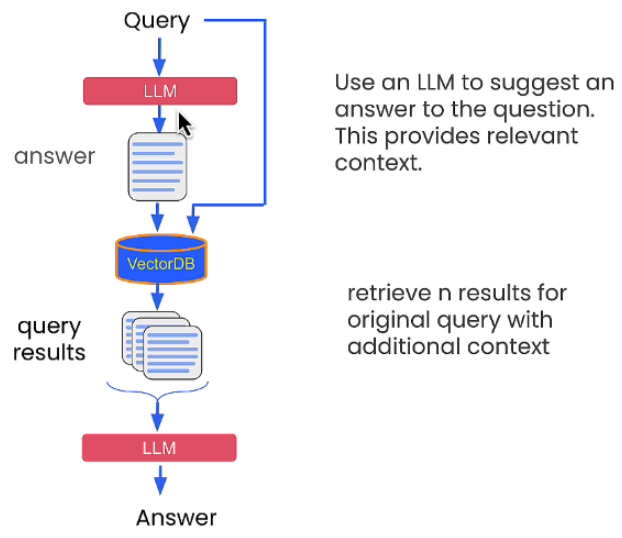

For a change we use an open source embedding model names Sentence Transformer (356 dimensionality)

In [5]:
from RAG_Workshop_DHS2024.utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
chroma_collection = load_chroma(filename='/content/RAG_Workshop_DHS2024/data/Microsoft_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

455

Now let's make a function to generate a ficticious or hypothetical answer from an annual report for a given query

In [9]:
from langchain.prompts import PromptTemplate
from langchain.schema.output_parser import StrOutputParser

def augment_query_generated(query):
    chain = (
        PromptTemplate.from_template(
            """You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report.
            Question: {question}""")
        | llm | StrOutputParser()
    )
    return chain.invoke({'question':query})

Now we try to generate a hypothetical answer for a query and concatenate the two

In [10]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)
joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? **Example
Answer:**

During the fiscal year 2023, the company experienced notable
turnover within its executive team. Specifically, we welcomed three new
members to the executive leadership team: Jane Doe as Chief Financial
Officer, John Smith as Chief Technology Officer, and Emily Johnson as
Chief Marketing Officer. These appointments followed the departures of
former executives, including the previous CFO, who retired after a
distinguished 20-year career with the company, and the CTO, who left to
pursue other opportunities.

The transition in leadership is part of
our strategic initiative to enhance our operational capabilities and
drive innovation. The new executives bring a wealth of experience from
diverse industries, which we believe will be instrumental in achieving
our long-term growth objectives. We are committed to ensuring a smooth
transition and have implemented a comprehensive onboarding process to
integrate the new lea

Now we got a joint query which is a combination of thr original query and the hypothetical answer (generated by LLM)

Let' try to get top 5 documents from chroma collections which are close to the join query

In [11]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

# Print the retrieved documents
for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

part i item 1 20 information about our executive officers our executive
officers as of july 28, 202 2 were as follows : name age position with
the company satya nadella 54 chairman of the board and chief executive
officer judson althoff 49 executive vice president and chief commercial
officer christopher c. capossela 52 executive vice president, marketing
and consumer business, and chief marketing officer kathleen t. hogan 56
executive vice president, human resources amy e. hood 50 executive vice
president, chief financial officer bradford l. smith 63 president and
vice chair christopher d. young 50 executive vice president, business
development, strategy, and ventures mr. nadella was appointed chairman
of the board in june 2021 and chief executive officer in february 2014.
he

officer in july 2016. he had served as executive vice president, chief
marketing officer since march 2014. previously, he served as the
worldwide lea der of the consumer channels group, responsible for sales
and

In [12]:
import umap

# get the embeddings from the chroma collections
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']

# Perform umap fit on the high dimensional embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 455/455 [08:45<00:00,  1.16s/it]


In [13]:
# Number of docs retrieved
len(results['embeddings'][0])

5

In [14]:
# Embedding vector length of each doc retrieved
len(results['embeddings'][0][0])

384

In [15]:
# get the embedding vectors for all the retrieved documents from the results obj.
retrieved_embeddings = results['embeddings'][0]

# Get the embedding for the original and the joint query
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

# Get the 2D umap fit of the original query
projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)

# Get the 2D umap fit of joint query
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)

# Get the 2D umap fit of the docs retrived using the joint query
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


### Plot the projected query and retrieved documents in the embedding space

(3.94925594329834, 14.962620735168457, 4.583717298507691, 13.255894708633424)

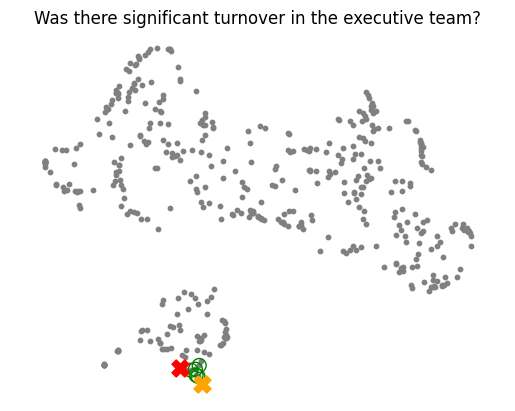

In [16]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

#### Technique 2 - Query expansion with multiple queries
Given an input query, this method instructs an LLM to generate N questions related to the original query and then sends them all (+ the original query) to the retrieval system.

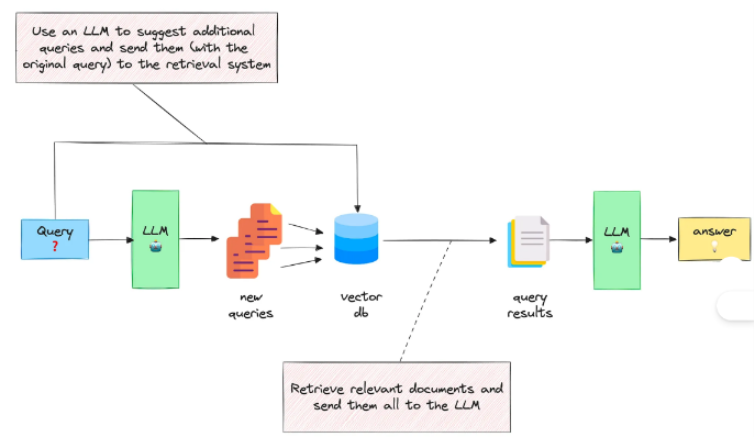

Make multiple queries for the original query using an LLM

In [17]:
def augment_multiple_query(query):
    chain = (
        PromptTemplate.from_template(
            """You are a helpful expert financial research assistant. Your users are asking questions about an annual report.
            Suggest up to five additional related questions to help them find the information they need, for the provided question.
            Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.
            Make sure they are complete questions, and that they are related to the original question.
            Output one question per line
            Quesion: {question}""")
        | llm
        | StrOutputParser()
    )
    return chain.invoke({'question':query})

In [18]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)
augmented_queries = augmented_queries.split('\n')

for query in augmented_queries:
    print(query)

What were the key revenue streams for the company?  
How did market trends impact revenue growth?  
What role did pricing strategies play in revenue increases?  
Were there any significant changes in customer demographics?  
How did the company's expenses affect overall profitability?  


In [19]:
# Combine original and augmented queries
queries = [original_query] + augmented_queries
queries

['What were the most important factors that contributed to increases in revenue?',
 'What were the key revenue streams for the company?  ',
 'How did market trends impact revenue growth?  ',
 'What role did pricing strategies play in revenue increases?  ',
 'Were there any significant changes in customer demographics?  ',
 "How did the company's expenses affect overall profitability?  "]

In [20]:
# Get the 5 docs which are pretty close to each query in the queries list
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])


In [21]:
len(results['documents'][0])

5

In [22]:
retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 4 4, respectively. prior
year net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 million and $ 0. 08, r espectively. gross margin and operating
income both included an unfavorable foreign currency impact of 2 %.
segment results of operations ( in millions, except percentages ) 2022
2021 percentage change revenue productivity and business processes $
63, 364 $ 53, 915 18 % intelligent cloud 75, 251 60, 080 25 % more
pers

In [23]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


In [24]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:35<00:00,  1.20s/it]


(3.94925594329834, 14.962620735168457, 4.777962231636048, 13.246644949913025)

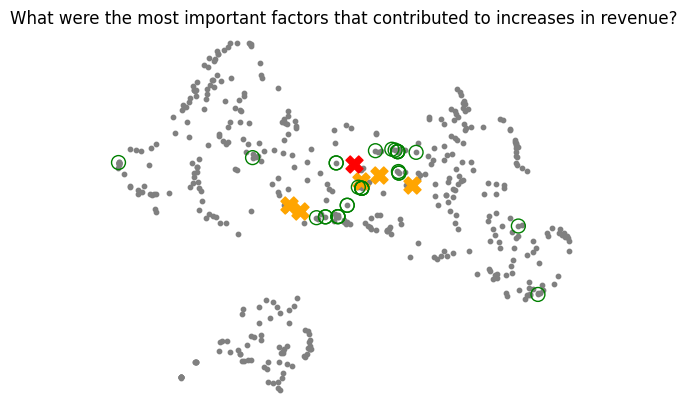

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Query Expansion with cross encoder Re ranking

Cross encoding is a combination of multiple queries and cross encoder re ranking, as user able to generate more questions using LLM, each generated query will able to extract couple of documents from vector database.

Those extracted documents must be passed through a cross-encoder to obtain similarity scores with the initial query. Now we can re ranking does relevant document and pick top 5 to be used as context of our LLM summarization.

Why we need to pick the top 5 documents? In this case we try to avoid the irrelevant documents that we retrieved from vector database. This selection ensures that the cross-encoder focuses on the most similar and meaningful documents, thereby generating a more accurate and concise summary.


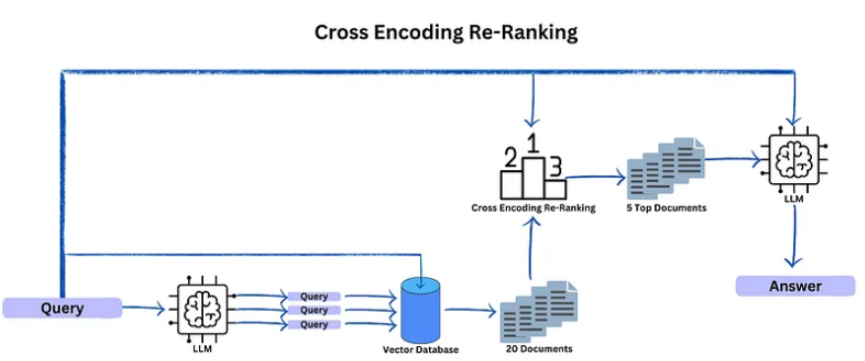

In [27]:
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

#Cross Encoding happens in here
def create_documents(queries, retrieved_documents):

    retrieved_documents = [element for sublist in retrieved_documents for element in sublist]
    unique_a = []
    #If there is duplication documents for each query, make it unique
    for item in retrieved_documents:
        if item not in unique_a:
            unique_a.append(item)

    unique_documents = list(unique_a)

    pairs = []
    for doc in unique_documents:
        pairs.append([queries[0], doc])

    #Cross Encoder Scoring
    scores = cross_encoder.predict(pairs)

    final_queries = []
    for x in range(len(scores)):
        final_queries.append({"score":scores[x],"document":unique_documents[x]})

    #Rerank the documents, return top 5
    sorted_list = sorted(final_queries, key=lambda x: x["score"], reverse=True)
    first_five_elements = sorted_list[:6]
    return first_five_elements

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## QnA

In [28]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from IPython.display import Markdown

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """Assistant is a large language model trained by OpenAI. \
        Use the following pieces of retrieved context to answer the question. \
        If you don't know the answer, just say that you don't know. \

        {context}"""),

        ("human", "{question}"),
    ]
)

def format_docs(docs):
    doc_strings = [doc["document"] for doc in docs]
    return "\n\n".join(doc_strings)

top5_docs = create_documents(augmented_queries, retrieved_documents)

chain =  qa_prompt | llm| StrOutputParser()

### Before Query Expansion & Cross Encoder Re-ranking

In [29]:
original_query

'What were the most important factors that contributed to increases in revenue?'

In [30]:
len(retrieved_documents)

6

In [31]:
result = chain.invoke({"question":original_query, "context": '\n\n'.join([doc for doc in retrieved_documents[0]])})
Markdown(result)

The most important factors that contributed to increases in revenue include:

1. **Growth Across Segments**: Revenue growth was driven by increases in each of the company's segments, including productivity and business processes, intelligent cloud, and more personal computing.

2. **Higher Revenue per Search and Search Volume**: There was a significant increase in revenue from search services, attributed to higher revenue per search and increased search volume.

3. **Gaming Revenue Growth**: Gaming revenue increased due to strong demand for Xbox hardware (specifically the Xbox Series X|S) and growth in Xbox content and services, including subscriptions to Xbox Game Pass.

4. **Investments in Marketing and Corporate Functions**: Increased investments in marketing for gaming, search and news advertising, and Windows contributed to revenue growth.

5. **Demand for Products**: Continued demand for products like Xbox hardware and growth in services related to those products also played a role in increasing revenue.

6. **Positive Tax Benefits**: The current year net income and diluted EPS were positively impacted by a net tax benefit related to the transfer of intangible properties, which indirectly supports revenue growth.

These factors collectively contributed to the overall increase in revenue reported.

### After Query Expansion & Re-ranking

In [32]:
top5_docs

[{'score': -7.4716926,
  'document': 'revenue and costs are generally directly attributed to our segments. however, due to the integrated structure of our business, certain revenue recognized and costs incurred by one segment may benefit other segments. revenue from certain contracts is alloca ted among the segments based on the relative value of the underlying products and services, which can include allocation based on actual prices charged, prices when sold separately, or estimated costs plus a profit margin. cost of revenue is allocated in c ertain cases based on a relative revenue methodology. operating expenses that are allocated primarily include those relating to marketing of products and services from which multiple segments benefit and are generally allocated based on relative gross marg in. in addition, certain costs incurred at a corporate level that are identifiable and that benefit our segments are allocated'},
 {'score': -7.7334623,
  'document': 'part ii item 7 42 • off

In [33]:
result = chain.invoke({"question":original_query, "context": format_docs(top5_docs)})
display(Markdown(result))
top5_docs

The most important factors that contributed to increases in revenue included:

1. **Growth in Microsoft 365 Consumer Subscriptions**: Office consumer products and cloud services revenue increased significantly due to a 15% growth in Microsoft 365 consumer subscribers, reaching 59.7 million.

2. **Strong Performance of LinkedIn**: LinkedIn revenue increased by 34%, driven by a strong job market in the talent solutions business and increased advertising demand in the marketing solutions business.

3. **Dynamics 365 Growth**: Dynamics products and cloud services revenue increased by 25%, with Dynamics 365 experiencing a growth of 39%.

4. **Cloud Services Expansion**: Microsoft cloud revenue (formerly commercial cloud) increased by 32%, with significant growth in Azure and other cloud services, which grew by 45%.

5. **Office Commercial Products Growth**: Office commercial products and cloud services revenue increased by 13%, driven by an 18% growth in Office 365 commercial.

6. **Windows OEM and Commercial Revenue**: Windows OEM revenue increased by 11%, supported by strength in the commercial PC market, while Windows commercial products and cloud services revenue also increased by 11%.

7. **Search and News Advertising Revenue**: This revenue increased by 27%, reflecting strong demand in that segment.

These factors collectively contributed to the overall revenue growth reported for the fiscal year.

[{'score': -7.4716926,
  'document': 'revenue and costs are generally directly attributed to our segments. however, due to the integrated structure of our business, certain revenue recognized and costs incurred by one segment may benefit other segments. revenue from certain contracts is alloca ted among the segments based on the relative value of the underlying products and services, which can include allocation based on actual prices charged, prices when sold separately, or estimated costs plus a profit margin. cost of revenue is allocated in c ertain cases based on a relative revenue methodology. operating expenses that are allocated primarily include those relating to marketing of products and services from which multiple segments benefit and are generally allocated based on relative gross marg in. in addition, certain costs incurred at a corporate level that are identifiable and that benefit our segments are allocated'},
 {'score': -7.7334623,
  'document': 'part ii item 7 42 • off